# Imports

In [1]:
import os
import pandas as pd
import numpy as np
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
import shap
import textwrap
import logging

from tqdm import tqdm
#from matplotlib import pyplot
#from skopt import BayesSearchCV
#from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, ParameterGrid, train_test_split, ParameterSampler
#from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error, mean_squared_log_error, r2_score


from hyperopt import fmin, tpe, hp, Trials
from hyperopt.pyll.base import scope

#from keras.models import Sequential
#from keras.layers import LSTM, Dense, Dropout, Input
#from keras.callbacks import EarlyStopping

In [2]:
# Set up logging
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
    handlers=[
        logging.FileHandler("logging.log"),
        logging.StreamHandler()
    ]
)

In [3]:
# Set the name for the files
file_name = "01_seq_01"

In [ ]:
total_test_val_perc = 0.2
split_between_test_val_perc = 0.5

# Group data by subject_id and hadm_id
grouped_df = mimic_df.groupby(['subject_id', 'hadm_id'])

# Get a new dataframe with one row per patient (subject_id, hadm_id) pair
patient_df = grouped_df['hospital_expire_flag'].first().reset_index()

# Split the patient_df into training (80%), validation (10%), and test (10%) while keeping the ratio of hospital_expired_flag
train, temp = train_test_split(patient_df, test_size=total_test_val_perc, stratify=patient_df['hospital_expire_flag'], random_state=42)
val, test = train_test_split(temp, test_size=split_between_test_val_perc, stratify=temp['hospital_expire_flag'], random_state=42)

# Step 4: Merge back with the original df to get the rows for each patient in the splits
train_df = mimic_df.merge(train[['subject_id', 'hadm_id']], on=['subject_id', 'hadm_id'], how='inner')
val_df = mimic_df.merge(val[['subject_id', 'hadm_id']], on=['subject_id', 'hadm_id'], how='inner')
test_df = mimic_df.merge(test[['subject_id', 'hadm_id']], on=['subject_id', 'hadm_id'], how='inner')

# Check the sizes of the splits
print(f'Training set size: {train_df.shape[0]}')
print(f'Validation set size: {val_df.shape[0]}')
print(f'Test set size: {test_df.shape[0]}')

# Load Train - Validation - Test & External Validation Sets

In [6]:
# Path to the saved files
folder = 'seq_01'
observation_window = 'o4'
label = 'los'

load_path = f'../../07_Imputation/CSV/exports/CIR-16/impute/{folder}/'

# Load external validation set from eICU
X_external = pd.read_csv(load_path + f'{observation_window}_X_external.csv')
y_external = pd.read_csv(load_path + f'{observation_window}_y_external_{label}.csv')

# Load training, validation, and test sets
X_train = pd.read_csv(load_path + f'{observation_window}_X_train.csv')
y_train = pd.read_csv(load_path + f'{observation_window}_y_train_{label}.csv')

X_validate = pd.read_csv(load_path + f'{observation_window}_X_validate.csv')
y_validate = pd.read_csv(load_path + f'{observation_window}_y_validate_{label}.csv')

X_test = pd.read_csv(load_path + f'{observation_window}_X_test.csv')
y_test = pd.read_csv(load_path + f'{observation_window}_y_test_{label}.csv')

# Train Model without HP

In [7]:
# Default XGBoost Model
model = xgb.XGBRegressor(objective='reg:squarederror')

model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)

# Predict on the external validation set (eICU data)
y_pred_external = model.predict(X_external)

In [ ]:
# Define the chunked transformation function with a progress bar
def chunked_transform(imputer, X, chunk_size):
    X_imputed = []
    for i in tqdm(range(0, X.shape[0], chunk_size), desc="Imputing"):
        chunk = X.iloc[i:i+chunk_size]
        imputed_chunk = imputer.transform(chunk)
        X_imputed.append(imputed_chunk)
    return pd.DataFrame(np.vstack(X_imputed), columns=X.columns)

# Step 1: Create and fit the KNN imputer
knn_imputer = KNNImputer(n_neighbors=5)
knn_imputer.fit(X_train)

# Step 2: Apply imputation with specific chunk sizes for each dataset
X_train = chunked_transform(knn_imputer, X_train, chunk_size=1000)
X_validate = chunked_transform(knn_imputer, X_validate, chunk_size=512)
X_test = chunked_transform(knn_imputer, X_test, chunk_size=512)
X_external = chunked_transform(knn_imputer, X_external, chunk_size=2000)

# Step 3: Save to CSV
X_train.to_csv("CSV/exports/impute/o01_KNN/X_train.csv", index=False)
X_validate.to_csv("CSV/exports/impute/o01_KNN/X_validate.csv", index=False)
X_test.to_csv("CSV/exports/impute/o01_KNN/X_test.csv", index=False)
X_external.to_csv("CSV/exports/impute/o01_KNN/X_external.csv", index=False)

In [ ]:
"""
I should change the estimator and I'm gonna execute
scale and normalization first.

In the defult settings there is a big chagnes between
round 1 and round 3. The number of imputation makes
significant imcreasement. We expect from round to round
the change to be smaller. This behavior of causing the
model to make massive adjustments to certain predictions
shows that maybe one or more features have high variance
or outliers, thats why I'm gonna execute before imputation
scale and normalization.
"""

# Define the imputer
iter_imputer = IterativeImputer(estimator=ExtraTreesRegressor(n_estimators=10, random_state=0),
                                 max_iter=20, random_state=0, verbose=0)

# --- Impute Training Set ---
print("Imputing missing values on training set...")
with tqdm(total=1, desc="X_train") as pbar:
    X_train_imputed = iter_imputer.fit_transform(X_train)
    X_train = pd.DataFrame(X_train_imputed, columns=X_train.columns)
    pbar.update(1)

# --- Impute Validation Set ---
print("Imputing missing values on validation set...")
with tqdm(total=1, desc="X_validate") as pbar:
    X_validate_imputed = iter_imputer.transform(X_validate)
    X_validate = pd.DataFrame(X_validate_imputed, columns=X_validate.columns)
    pbar.update(1)

# --- Impute Test Set ---
print("Imputing missing values on test set...")
with tqdm(total=1, desc="X_test") as pbar:
    X_test_imputed = iter_imputer.transform(X_test)
    X_test = pd.DataFrame(X_test_imputed, columns=X_test.columns)
    pbar.update(1)

# --- Impute External Validation Set ---
print("Imputing missing values on external validation set...")
with tqdm(total=1, desc="X_external") as pbar:
    X_external_imputed = iter_imputer.transform(X_external)
    X_external = pd.DataFrame(X_external_imputed, columns=X_external.columns)
    pbar.update(1)

In [ ]:
# Define the interpolation method (you can use 'linear', 'polynomial', 'spline', etc.)
interpolation_method = 'linear'

# Interpolate missing values in X_train
X_train = X_train.interpolate(method=interpolation_method, axis=0, limit_direction='both')

# Interpolate missing values in X_validate
X_validate = X_validate.interpolate(method=interpolation_method, axis=0, limit_direction='both')

# Interpolate missing values in X_test
X_test = X_test.interpolate(method=interpolatbion_method, axis=0, limit_direction='both')

# Interpolate missing values in X_external
X_external = X_external.interpolate(method=interpolation_method, axis=0, limit_direction='both')

# Resetting indexes after interpolation to avoid misalignments
X_train = X_train.reset_index(drop=True)
X_validate = X_validate.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
X_external = X_external.reset_index(drop=True)

# Optionally, you can check if there are still any missing values
print(f"Missing values in X_train: {X_train.isnull().sum().sum()}")
print(f"Missing values in X_validate: {X_validate.isnull().sum().sum()}")
print(f"Missing values in X_test: {X_test.isnull().sum().sum()}")
print(f"Missing values in X_external: {X_external.isnull().sum().sum()}")

In [ ]:
# Define the interpolation method
interpolation_method = 'linear'

# Define your datasets
datasets = {
    "X_train": X_train,
    "X_validate": X_validate,
    "X_test": X_test,
    "X_external": X_external
}

# Create a progress bar using tqdm
for name in tqdm(datasets, desc="Interpolating datasets"):
    df = datasets[name]
    df_interpolated = df.interpolate(method=interpolation_method, axis=0, limit_direction='both')
    df_interpolated = df_interpolated.reset_index(drop=True)
    datasets[name] = df_interpolated
    print(f"Missing values in {name}: {df_interpolated.isnull().sum().sum()}")

# Unpack the updated datasets
X_train = datasets["X_train"]
X_validate = datasets["X_validate"]
X_test = datasets["X_test"]
X_external = datasets["X_external"]


In [ ]:
"""
Feedforward MLP (Multilayer Perceptron)
"""

from keras.callbacks import EarlyStopping
import numpy as np
import pandas as pd

# Define a function to impute missing values for any dataset independently
def impute_missing_values_ann(X, dataset_name):
    print(f"Imputing missing values for {dataset_name}")
    
    # Step 1: Identify columns with missing values
    missing_columns = X.columns[X.isnull().any()].tolist()
    print(f"Columns with missing values: {missing_columns}")

    # Step 2: Loop through each column with missing values and build an ANN to predict missing values
    for col in missing_columns:
        print(f"Filling missing values in column: {col}")

        # Separate rows with and without missing values in the current column
        missing_rows = X[X[col].isnull()]
        non_missing_rows = X[~X[col].isnull()]

        # Skip the column if no data is available for training
        if len(missing_rows) == 0 or len(non_missing_rows) == 0:
            print(f"Skipping {col}, insufficient data")
            continue

        # Separate features and target for non-missing rows
        X_non_missing = non_missing_rows.drop(columns=missing_columns).copy()  # Exclude other missing columns from features
        y_non_missing = non_missing_rows[col].copy()  # Target is the column we're filling

        # Features for the rows with missing values (we'll predict the column for these rows)
        X_missing = missing_rows.drop(columns=missing_columns).copy()

        # Step 3: Ensure all data is numeric and convert to float if necessary
        X_non_missing = X_non_missing.apply(pd.to_numeric, errors='coerce').astype(float)
        y_non_missing = y_non_missing.astype(float)
        X_missing = X_missing.apply(pd.to_numeric, errors='coerce').astype(float)

        # Step 4: Build the ANN model for filling missing values
        model_missing = Sequential()
        model_missing.add(Input(shape=(X_non_missing.shape[1],)))  # Input layer
        model_missing.add(Dense(units=128, activation='relu'))
        model_missing.add(Dropout(0.4))
        model_missing.add(Dense(units=64, activation='relu'))
        model_missing.add(Dropout(0.4))
        model_missing.add(Dense(units=32, activation='relu'))
        model_missing.add(Dense(units=1, activation='linear'))


        # Compile the model
        model_missing.compile(optimizer='adam', loss='mean_squared_error')

        # Early stopping to avoid overfitting
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

        # Step 5: Train the model
        model_missing.fit(X_non_missing, y_non_missing, 
                          epochs=50, batch_size=32, 
                          validation_split=0.1, 
                          callbacks=[early_stopping], verbose=0)

        # Step 6: Predict the missing values
        predicted_values = model_missing.predict(X_missing)

        # Step 7: Fill the missing values in the dataset
        X.loc[X[col].isnull(), col] = predicted_values

        print(f"Filled missing values in column: {col}")

    # Verify if there are any remaining missing values in the dataset
    print(X.isnull().sum())
    return X

# Impute missing values for each dataset independently to avoid data leakage

# Impute missing values for X_train
X_train_imputed = impute_missing_values_ann(X_train, "X_train")

# Impute missing values for X_test
X_test_imputed = impute_missing_values_ann(X_test, "X_test")

# Impute missing values for X_validate
X_validate_imputed = impute_missing_values_ann(X_validate, "X_validate")

# Impute missing values for X_external

X_external_imputed = impute_missing_values_ann(X_external, "X_external")

In [ ]:
"""
RNN
"""
# Define a function to impute missing values for any dataset independently using an RNN
def impute_missing_values_rnn(X, dataset_name):
    print(f"Imputing missing values for {dataset_name}")
    
    # Step 1: Identify columns with missing values
    missing_columns = X.columns[X.isnull().any()].tolist()
    print(f"Columns with missing values: {missing_columns}")

    # Step 2: Loop through each column with missing values and build an RNN to predict missing values
    for col in missing_columns:
        print(f"Filling missing values in column: {col}")

        # Separate rows with and without missing values in the current column
        missing_rows = X[X[col].isnull()]
        non_missing_rows = X[~X[col].isnull()]

        # Skip the column if no data is available for training
        if len(missing_rows) == 0 or len(non_missing_rows) == 0:
            print(f"Skipping {col}, insufficient data")
            continue

        # Separate features and target for non-missing rows
        X_non_missing = non_missing_rows.drop(columns=missing_columns).copy()  # Exclude other missing columns from features
        y_non_missing = non_missing_rows[col].copy()  # Target is the column we're filling

        # Features for the rows with missing values (we'll predict the column for these rows)
        X_missing = missing_rows.drop(columns=missing_columns).copy()

        # Step 3: Ensure all data is numeric and convert to float if necessary
        X_non_missing = X_non_missing.apply(pd.to_numeric, errors='coerce').astype(float)
        y_non_missing = y_non_missing.astype(float)
        X_missing = X_missing.apply(pd.to_numeric, errors='coerce').astype(float)

        # Step 4: Reshape the data to 3D for RNN input (samples, timesteps=1, features)
        X_non_missing_rnn = np.expand_dims(X_non_missing, axis=1)  # Add timestep dimension
        X_missing_rnn = np.expand_dims(X_missing, axis=1)

        # Step 5: Build the RNN model for filling missing values with Input layer
        model_missing = Sequential()
        model_missing.add(Input(shape=(1, X_non_missing.shape[1])))  # Input layer with timestep=1 and number of features
        model_missing.add(LSTM(units=64, return_sequences=False))  # LSTM layer
        model_missing.add(Dropout(0.3))
        model_missing.add(Dense(units=32, activation='relu'))
        model_missing.add(Dense(units=1, activation='linear'))  # Output layer for regression (predicting the missing value)

        # Compile the model
        model_missing.compile(optimizer='adam', loss='mean_squared_error')

        # Early stopping to avoid overfitting
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

        # Step 6: Train the model
        model_missing.fit(X_non_missing_rnn, y_non_missing, 
                          epochs=50, batch_size=32, 
                          validation_split=0.1, 
                          callbacks=[early_stopping], verbose=0)

        # Step 7: Predict the missing values
        predicted_values = model_missing.predict(X_missing_rnn)

        # Step 8: Fill the missing values in the dataset
        X.loc[X[col].isnull(), col] = predicted_values.flatten()

        print(f"Filled missing values in column: {col}")

    # Verify if there are any remaining missing values in the dataset
    print(X.isnull().sum())
    return X

# Impute missing values for each dataset independently to avoid data leakage

# Impute missing values for X_train
X_train_imputed = impute_missing_values_rnn(X_train, "X_train")

# Impute missing values for X_test
X_test_imputed = impute_missing_values_rnn(X_test, "X_test")

# Impute missing values for X_validate
X_validate_imputed = impute_missing_values_rnn(X_validate, "X_validate")

# Impute missing values for X_external
X_external_imputed = impute_missing_values_rnn(X_external, "X_external")

In [ ]:
"""
Just Scale
"""

# Identify binary categorical features
def identify_binary_categorical_features(df):
    binary_categorical_features = []
    for col in df.columns:
        unique_values = df[col].unique()
        if set(unique_values) == {0.0, 1.0}:
            binary_categorical_features.append(col)
    return binary_categorical_features


# Identify binary categorical features
binary_categorical_features = identify_binary_categorical_features(X_train)

# Exclude binary categorical features from scaling
numerical_features = [col for col in X_train.columns if col not in binary_categorical_features]

# Create scalers
standard_scaler = StandardScaler()
minmax_scaler = MinMaxScaler()


"""---------------------"""
# Fit and transform only numerical features
X_train_scaled = X_train.copy()
X_train_scaled[numerical_features] = standard_scaler.fit_transform(X_train[numerical_features])
X_train = X_train_scaled

"""---------------------"""

# Fit and transform only numerical features
X_test_scaled = X_test.copy()
X_test_scaled[numerical_features] = standard_scaler.fit_transform(X_test[numerical_features])
X_test = X_test_scaled


"""---------------------"""

# Fit and transform only numerical features
X_validate_scaled = X_validate.copy()
X_validate_scaled[numerical_features] = standard_scaler.fit_transform(X_validate[numerical_features])
X_validate = X_validate_scaled


"""---------------------"""

# Fit and transform only numerical features
X_external_scaled = X_external.copy()
X_external_scaled[numerical_features] = standard_scaler.fit_transform(X_external[numerical_features])
X_external = X_external_scaled


In [ ]:
"""
Only Normalization
"""

# Identify binary categorical features
def identify_binary_categorical_features(df):
    binary_categorical_features = []
    for col in df.columns:
        unique_values = df[col].unique()
        if set(unique_values) == {0.0, 1.0}:
            binary_categorical_features.append(col)
    return binary_categorical_features


# Identify binary categorical features
binary_categorical_features = identify_binary_categorical_features(X_train)

# Exclude binary categorical features from normalization
numerical_features = [col for col in X_train.columns if col not in binary_categorical_features]

# Create the Min-Max scaler
minmax_scaler = MinMaxScaler()

"""---------------------"""
# Fit and transform only numerical features (normalization)
X_train_normalized = X_train.copy()
X_train_normalized[numerical_features] = minmax_scaler.fit_transform(X_train[numerical_features])
X_train = X_train_normalized

"""---------------------"""

# Fit and transform only numerical features (normalization)
X_test_normalized = X_test.copy()
X_test_normalized[numerical_features] = minmax_scaler.fit_transform(X_test[numerical_features])
X_test = X_test_normalized

"""---------------------"""

# Fit and transform only numerical features (normalization)
X_validate_normalized = X_validate.copy()
X_validate_normalized[numerical_features] = minmax_scaler.fit_transform(X_validate[numerical_features])
X_validate = X_validate_normalized

"""---------------------"""

# Fit and transform only numerical features (normalization)
X_external_normalized = X_external.copy()
X_external_normalized[numerical_features] = minmax_scaler.fit_transform(X_external[numerical_features])
X_external = X_external_normalized


In [ ]:
"""
Scale and Normalize
"""

# Identify binary categorical features
def identify_binary_categorical_features(df):
    binary_categorical_features = []
    for col in df.columns:
        unique_values = df[col].unique()
        if set(unique_values) == {0.0, 1.0}:
            binary_categorical_features.append(col)
    return binary_categorical_features


# Identify binary categorical features
binary_categorical_features = identify_binary_categorical_features(X_train)

# Exclude binary categorical features from scaling
numerical_features = [col for col in X_train.columns if col not in binary_categorical_features]

# Create scalers
standard_scaler = StandardScaler()
minmax_scaler = MinMaxScaler()


"""---------------------"""
# Fit and transform only numerical features
X_train_scaled = X_train.copy()
X_train_scaled[numerical_features] = standard_scaler.fit_transform(X_train[numerical_features])
X_train = X_train_scaled

# Optionally, apply Min-Max normalization
X_train_normalized = X_train_scaled.copy()
X_train_normalized[numerical_features] = minmax_scaler.fit_transform(X_train_scaled[numerical_features])
X_train = X_train_normalized


"""---------------------"""

# Fit and transform only numerical features
X_test_scaled = X_test.copy()
X_test_scaled[numerical_features] = standard_scaler.fit_transform(X_test[numerical_features])
X_test = X_test_scaled

# Optionally, apply Min-Max normalization
X_test_normalized = X_test_scaled.copy()
X_test_normalized[numerical_features] = minmax_scaler.fit_transform(X_test_scaled[numerical_features])
X_test = X_test_normalized


"""---------------------"""

# Fit and transform only numerical features
X_validate_scaled = X_validate.copy()
X_validate_scaled[numerical_features] = standard_scaler.fit_transform(X_validate[numerical_features])
X_validate = X_validate_scaled

# Optionally, apply Min-Max normalization
X_validate_normalized = X_validate_scaled.copy()
X_validate_normalized[numerical_features] = minmax_scaler.fit_transform(X_validate_scaled[numerical_features])
X_validate = X_validate_normalized


"""---------------------"""

# Fit and transform only numerical features
X_external_scaled = X_external.copy()
X_external_scaled[numerical_features] = standard_scaler.fit_transform(X_external[numerical_features])
X_external = X_external_scaled

# Optionally, apply Min-Max normalization
X_external_normalized = X_external_scaled.copy()
X_external_normalized[numerical_features] = minmax_scaler.fit_transform(X_external_scaled[numerical_features])
X_external = X_external_normalized

# HP GridSearchCV
## To slow

In [ ]:
"""
A smaller learning rate makes the boosting
process more robust and can lead to better
generalization but requires more trees
(higher n_estimators) to achieve the same result.
A larger learning rate speeds up training bu
may risk overfitting.
"""

# Define the parameter grid

param_grid = {
    'n_estimators': [100, 200, 300], # controls the total number of trees in the ensemble
    'learning_rate': np.arange(0.01, 1.02, 0.2),
    'max_depth': np.arange(1, 10, 1),
    'reg_lambda': np.arange(0.1, 15.1, 1),
    'reg_alpha': np.arange(0.1, 15.1, 1)
}

# Create an XGBoost Regressor
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

# Create GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                           scoring='neg_mean_squared_error', 
                           cv=3,  # Number of folds for cross-validation
                           verbose=1)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Best parameters and best score
print("Best parameters:", grid_search.best_params_)
print("Best score (negative MSE):", grid_search.best_score_)

# Predict on the validation set with the best model
y_pred_validate = grid_search.predict(X_validate)

# Optionally: Evaluate the model on the validation set
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_validate, y_pred_validate)
print("Validation MSE:", mse)

# HP RandomizedSearchCV & Train Model
Choose randomly samples a subset of hyperparameter combinations

In [ ]:
# Define the parameter grid
param_distributions = {
    'n_estimators': [100, 200, 300],
    'learning_rate': np.arange(0.01, 1.02, 0.2),
    'max_depth': np.arange(1, 10, 1),
    'reg_lambda': np.arange(0.1, 15.1, 1),
    'reg_alpha': np.arange(0.1, 15.1, 1)
}

# Number of random samples
n_iter = 50

# Generate random combinations
param_list = list(ParameterSampler(param_distributions, n_iter=n_iter, random_state=42))

# Tracking best model
best_score = float('inf')
best_params = None
best_model = None

# Progress bar
for params in tqdm(param_list, desc="Hyperparameter tuning"):
    model = xgb.XGBRegressor(objective='reg:squarederror', **params)
    model.fit(X_train, y_train)
    
    # Predict on validation set
    y_pred_val = model.predict(X_validate)
    
    # Evaluate with MSE
    mse = mean_squared_error(y_validate, y_pred_val)
    
    if mse < best_score:
        best_score = mse
        best_params = params
        best_model = model

# Evaluate best model on test set
y_pred = best_model.predict(X_test)
mse_test = mean_squared_error(y_test, y_pred)
mae_test = mean_absolute_error(y_test, y_pred)

# Evaluate on external validation set
y_pred_external = best_model.predict(X_external)
mse_external = mean_squared_error(y_external, y_pred_external)
mae_external = mean_absolute_error(y_external, y_pred_external)

# Results
logging.info(f"Best parameters: {best_params}")
logging.info(f"Best validation MSE: {best_score}")
logging.info(f"Test Set - MSE: {mse_test}, MAE: {mae_test}")
logging.info(f"External Validation Set - MSE: {mse_external}, MAE: {mae_external}")

# HP Bayesian Optimization & Train Model

In [ ]:
# Initialize tqdm progress bar
pbar = tqdm(total=50, desc="Bayesian Optimization Progress")

# Callback to update tqdm
def on_step(optim_result):
    pbar.update(1)

# Define the parameter search space
param_space = {
    'n_estimators': (100, 300),
    'learning_rate': (0.01, 1.0, 'log-uniform'),
    'max_depth': (1, 10),
    'reg_lambda': (0.1, 15.0),
    'reg_alpha': (0.1, 15.0)
}

# Create the XGBoost Regressor
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

# Create BayesSearchCV for Bayesian Optimization
bayes_search = BayesSearchCV(
    estimator=xgb_model,
    search_spaces=param_space,
    scoring='neg_mean_squared_error',
    n_iter=50,
    cv=3,
    verbose=0,
    random_state=42
)

# Fit BayesSearchCV with tqdm callback
bayes_search.fit(X_train, y_train, callback=on_step)
pbar.close()

# Log best parameters and score
logging.info("Best parameters: %s", bayes_search.best_params_)
logging.info("Best score (negative MSE): %.4f", bayes_search.best_score_)

# Predict on the validation set with the best model
y_pred_validate = bayes_search.predict(X_validate)

# Evaluate the model on the validation set
mse_validate = mean_squared_error(y_validate, y_pred_validate)
mae_validate = mean_absolute_error(y_validate, y_pred_validate)
logging.info("Validation MSE: %.4f", mse_validate)
logging.info("Validation MAE: %.4f", mae_validate)

# Extract the best hyperparameters from BayesSearchCV
best_params = bayes_search.best_params_

# Initialize the XGBoost model with the best hyperparameters
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=best_params['n_estimators'],
    learning_rate=best_params['learning_rate'],
    max_depth=best_params['max_depth'],
    reg_lambda=best_params['reg_lambda'],
    reg_alpha=best_params['reg_alpha']
)

# Train the model on the training set
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Predict on the external validation set (eICU data)
y_pred_external = model.predict(X_external)

# Evaluate the model on the test set
mse_test = mean_squared_error(y_test, y_pred)
mae_test = mean_absolute_error(y_test, y_pred)

# Evaluate the model on the external validation set
mse_external = mean_squared_error(y_external, y_pred_external)
mae_external = mean_absolute_error(y_external, y_pred_external)

# Log final evaluation metrics
logging.info("Test Set - MSE: %.4f, MAE: %.4f", mse_test, mae_test)
logging.info("External Validation Set (eICU) - MSE: %.4f, MAE: %.4f", mse_external, mae_external)

# HP HyperOpt & Train Model

In [ ]:
# Define the number of evaluations
MAX_EVALS = 50

# Initialize tqdm progress bar
pbar = tqdm(total=MAX_EVALS, desc="HyperOpt Progress")

# Define the wrapped objective function
def objective(params):
    model = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=int(params['n_estimators']),
        learning_rate=params['learning_rate'],
        max_depth=int(params['max_depth']),
        reg_lambda=params['reg_lambda'],
        reg_alpha=params['reg_alpha']
    )
    
    # Fit the model
    model.fit(X_train, y_train)
    
    # Predict on the validation set
    y_pred_validate = model.predict(X_validate)
    
    # Compute the MSE
    mse = mean_squared_error(y_validate, y_pred_validate)

    # Log the result
    logging.info("Params: %s | Validation MSE: %.4f", params, mse)
    
    # Update progress bar
    pbar.update(1)

    return {'loss': mse, 'status': 'ok'}

# Define the parameter search space
param_space = {
    'n_estimators': scope.int(hp.quniform('n_estimators', 100, 300, 50)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(1.0)),
    'max_depth': scope.int(hp.quniform('max_depth', 1, 10, 1)),
    'reg_lambda': hp.uniform('reg_lambda', 0.1, 15.0),
    'reg_alpha': hp.uniform('reg_alpha', 0.1, 15.0)
}

# Create a Trials object to keep track of the search
trials = Trials()

# Perform the hyperparameter search
best = fmin(
    fn=objective,
    space=param_space,
    algo=tpe.suggest,
    max_evals=MAX_EVALS,
    trials=trials,
    show_progressbar=False  # Disable internal bar to avoid overlap with tqdm
)

# Close progress bar
pbar.close()

# Log the best parameters
logging.info("Best parameters: %s", best)

# Initialize the XGBoost model with the best hyperparameters
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=int(best['n_estimators']),
    learning_rate=best['learning_rate'],
    max_depth=int(best['max_depth']),
    reg_lambda=best['reg_lambda'],
    reg_alpha=best['reg_alpha']
)

# Train the model on the training set
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Predict on the external validation set (eICU data)
y_pred_external = model.predict(X_external)

# Evaluate the model on the test set
mse_test = mean_squared_error(y_test, y_pred)
mae_test = mean_absolute_error(y_test, y_pred)

# Evaluate the model on the external validation set
mse_external = mean_squared_error(y_external, y_pred_external)
mae_external = mean_absolute_error(y_external, y_pred_external)

# Log final evaluation results
logging.info("Test Set - MSE: %.4f, MAE: %.4f", mse_test, mae_test)
logging.info("External Validation Set (eICU) - MSE: %.4f, MAE: %.4f", mse_external, mae_external)

In [ ]:
# Path
save_path = 'CSV/exports/impute/o03_Interpolation/'

# Check if the directory exists, and if not, create it
if not os.path.exists(save_path):
    os.makedirs(save_path)

# Save external validation set from eICU
X_external.to_csv(save_path + 'X_external.csv', index=False)
y_external.to_csv(save_path + 'y_external.csv', index=False)

# Save training, validation, and test sets
X_train.to_csv(save_path + 'X_train.csv', index=False)
y_train.to_csv(save_path + 'y_train.csv', index=False)

X_validate.to_csv(save_path + 'X_validate.csv', index=False)
y_validate.to_csv(save_path + 'y_validate.csv', index=False)

X_test.to_csv(save_path + 'X_test.csv', index=False)
y_test.to_csv(save_path + 'y_test.csv', index=False)

# Save Model

In [ ]:
# Define the directory and file path

name = f"{file_name}_model.json"
directory = 'models/'

file_path = os.path.join(directory, name)

# Create the directory if it does not exist
os.makedirs(directory, exist_ok=True)

# Save the model as a JSON file
model.save_model(file_path)

# Load Model

In [ ]:
# Define the model file path
file_name = "06"  # replace with the actual name you used before saving
directory = 'models/'
file_path = os.path.join(directory, f"{file_name}_model.json")

# Load the model
model = xgb.XGBRegressor()
model.load_model(file_path)

# Predict on the test set
y_pred = model.predict(X_test)

# Predict on the external validation set
y_pred_external = model.predict(X_external)

# Test Set Plots

Test Set MSE: 4.7063
Test Set MAE: 1.7996
Test Set RMSE: 2.1694
Test Set R2: 6.8102
Test Set MSLE: 0.3011


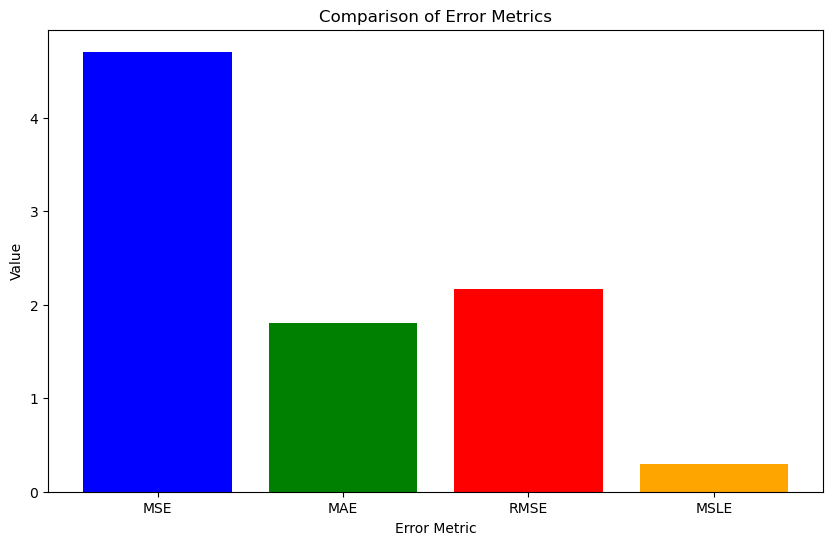

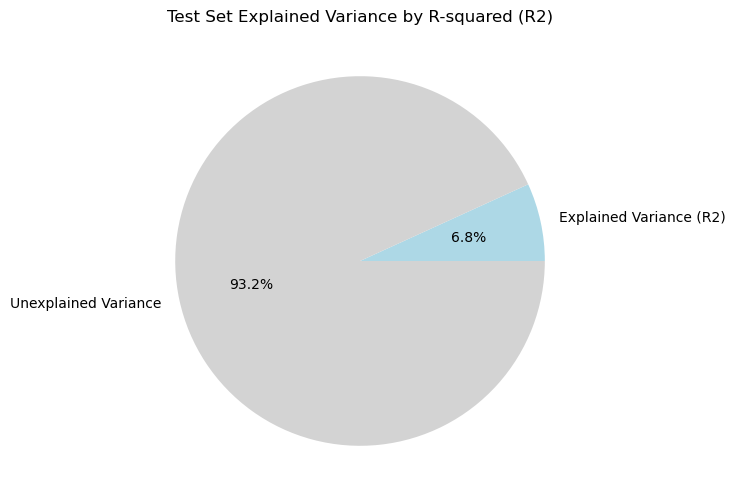

In [8]:
# Metrics calculation
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred) * 100

print(f"Test Set MSE: {mse:.4f}")
print(f"Test Set MAE: {mae:.4f}")
print(f"Test Set RMSE: {rmse:.4f}")
print(f"Test Set R2: {r2:.4f}")

# Initialize error metrics
error_metrics = ['MSE', 'MAE', 'RMSE']
values = [mse, mae, rmse]

# Try to calculate MSLE
try:
    msle = mean_squared_log_error(y_test, y_pred)
    print(f"Test Set MSLE: {msle:.4f}")
    
    # Add MSLE to the list of metrics if applicable
    error_metrics.append('MSLE')
    values.append(msle)
except ValueError:
    print("Mean Squared Logarithmic Error cannot be calculated because targets contain negative values.")

# Plot error metrics (with or without MSLE)
plt.figure(figsize=(10, 6))
plt.bar(error_metrics, values, color=['blue', 'green', 'red', 'orange'][:len(error_metrics)])
plt.xlabel('Error Metric')
plt.ylabel('Value')
plt.title('Comparison of Error Metrics')

output_path = f"plots/03_Error_Metric_Plots/{file_name}_internal_error_metrics.png"
os.makedirs(os.path.dirname(output_path), exist_ok=True)

plt.savefig(output_path, dpi=300, bbox_inches='tight')
plt.show()

# Plotting R-squared (R2) for the test set
plt.figure(figsize=(6, 6))

if r2 >= 0:
    plt.pie([r2, 100 - r2], 
            labels=['Explained Variance (R2)', 'Unexplained Variance'], 
            colors=['lightblue', 'lightgrey'], autopct='%1.1f%%')
else:
    plt.pie([100], labels=['Unexplained Variance'], colors=['lightgrey'], autopct='%1.1f%%')

plt.title('Test Set Explained Variance by R-squared (R2)')
output_path = f"plots/03_Error_Metric_Plots/{file_name}_internal_R2.png"
os.makedirs(os.path.dirname(output_path), exist_ok=True)
plt.savefig(output_path, dpi=300, bbox_inches='tight')
plt.show()

# External Validation Plots

External Validation Set MSE: 8.2710
External Validation Set MAE: 2.4191
External Validation Set RMSE: 2.8759
External Validation Set R2: -88.7150
External Validation Set MSLE: 0.5460


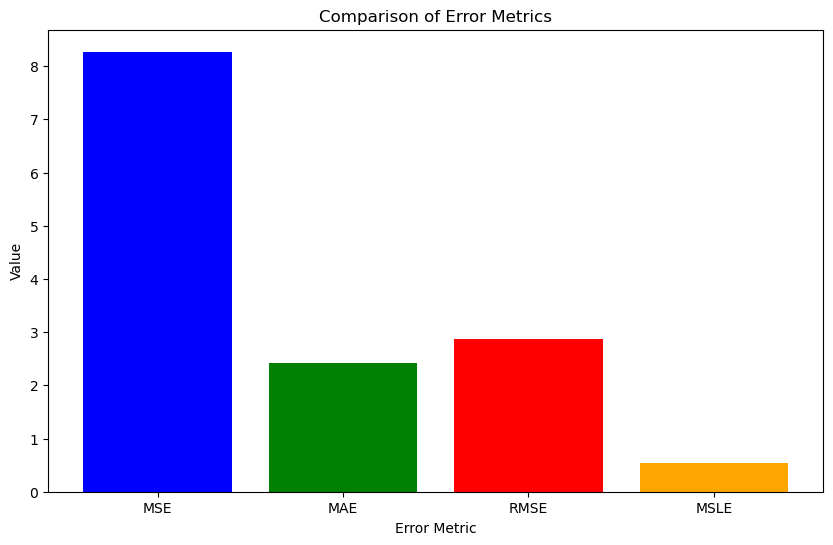

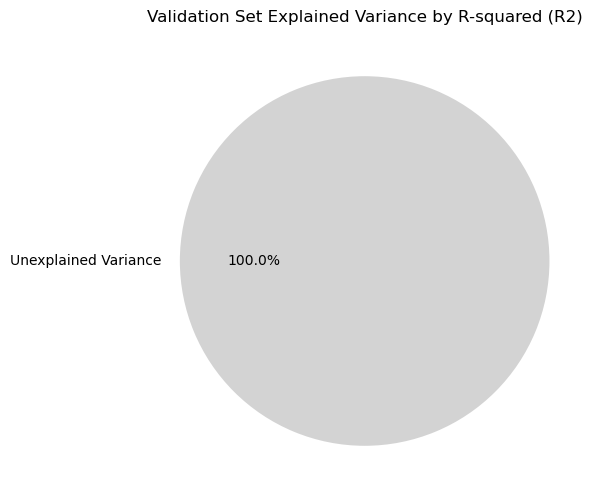

In [9]:
# Predict on the external validation set (eICU data)
y_pred_external = model.predict(X_external)

# Metrics for external validation set
mse_external = mean_squared_error(y_external, y_pred_external)
mae_external = mean_absolute_error(y_external, y_pred_external)
rmse_external = np.sqrt(mse_external)
r2_external = r2_score(y_external, y_pred_external) * 100

print(f"External Validation Set MSE: {mse_external:.4f}")
print(f"External Validation Set MAE: {mae_external:.4f}")
print(f"External Validation Set RMSE: {rmse_external:.4f}")
print(f"External Validation Set R2: {r2_external:.4f}")

# Initialize error metrics
error_metrics = ['MSE', 'MAE', 'RMSE']
values = [mse_external, mae_external, rmse_external]

# Try to calculate MSLE
try:
    msle_external = mean_squared_log_error(y_external, y_pred_external)
    print(f"External Validation Set MSLE: {msle_external:.4f}")
    
    # Add MSLE to the list of metrics if applicable
    error_metrics.append('MSLE')
    values.append(msle_external)
except ValueError:
    print("Mean Squared Logarithmic Error cannot be calculated because targets contain negative values.")

# Plot error metrics (with or without MSLE)
plt.figure(figsize=(10, 6))
plt.bar(error_metrics, values, color=['blue', 'green', 'red', 'orange'][:len(error_metrics)])
plt.xlabel('Error Metric')
plt.ylabel('Value')
plt.title('Comparison of Error Metrics')


output_path = f"plots/03_Error_Metric_Plots/{file_name}_external_error_metrics.png"
os.makedirs(os.path.dirname(output_path), exist_ok=True)
plt.savefig(output_path, dpi=300, bbox_inches='tight')
plt.show()

# Plotting R-squared (R2) for the external validation set
plt.figure(figsize=(6, 6))

if r2_external >= 0:
    plt.pie([r2_external, 100 - r2_external], 
            labels=['Explained Variance (R2)', 'Unexplained Variance'], 
            colors=['lightblue', 'lightgrey'], autopct='%1.1f%%')
else:
    plt.pie([100], labels=['Unexplained Variance'], colors=['lightgrey'], autopct='%1.1f%%')

plt.title('Validation Set Explained Variance by R-squared (R2)')

output_path = f"plots/03_Error_Metric_Plots/{file_name}_external_R2.png"
os.makedirs(os.path.dirname(output_path), exist_ok=True)
plt.savefig(output_path, dpi=300, bbox_inches='tight')
plt.show()

# Calibration Plot

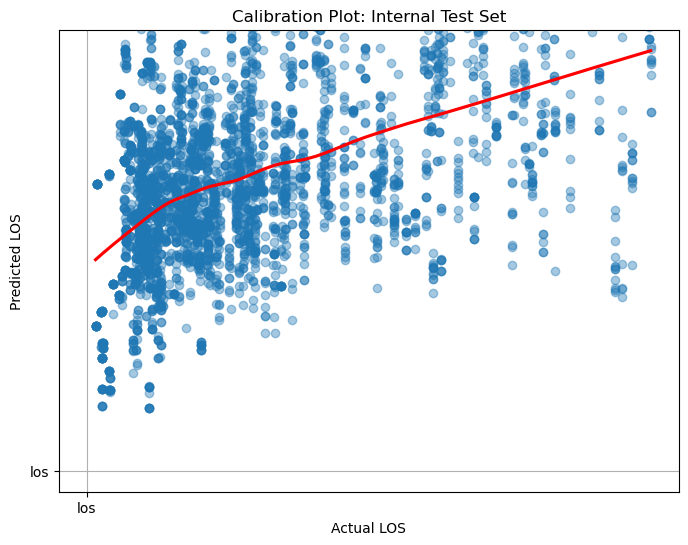

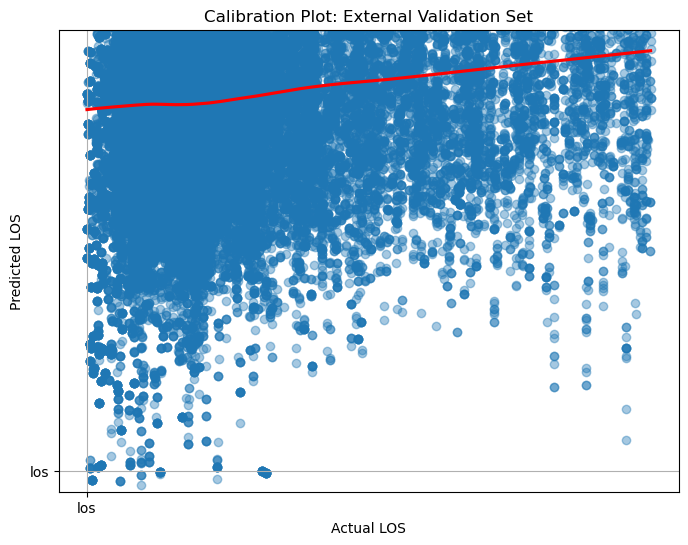

In [10]:
# Function to create calibration plot
def plot_calibration(y_true, y_pred, title, filename):
    plt.figure(figsize=(8, 6))
    sns.regplot(x=y_true, y=y_pred, lowess=True, line_kws={'color': 'red'}, scatter_kws={'alpha': 0.4})
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'k--', lw=2)
    plt.xlabel('Actual LOS')
    plt.ylabel('Predicted LOS')
    plt.title(f'Calibration Plot: {title}')
    plt.grid(True)

    output_path = f"plots/04_Calibration_Plots/{filename}.png"
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.show()

# Plot for test set
plot_calibration(y_test, y_pred, "Internal Test Set", f"{file_name}_calibration_internal")

# Plot for external set
plot_calibration(y_external, y_pred_external, "External Validation Set", f"{file_name}_calibration_external")

# Most important features

In [11]:
# Get feature importances
most_important_df = model.feature_importances_

# Create a DataFrame to store feature importances along with their corresponding names
most_important_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': most_important_df})

# Sort the DataFrame by feature importance in descending order
most_important_df = most_important_df.sort_values(by='Importance', ascending=False)

# Scale the importance
most_important_df['Importance'] *= 100000

# Print the top N most important features
top_n = 20  # set features number
print(f"Top {top_n} most important features:")
print(most_important_df.head(top_n))

Top 20 most important features:
                                              Feature   Importance
308                                          pH_(Min)  6115.332031
25     Arterial_Blood_Pressure_diastolic_(mmHg)_(Max)  5359.005371
68                         Calculated_Total_CO2_(Min)  3867.553467
296                                   Uric_Acid_(Min)  2404.027832
307                                       pH_(Median)  1345.748779
245   Pulmonary_Artery_Pressure_systolic_(mmHg)_(Max)  1156.599854
143                               Hemoglobin_(Median)  1148.301636
306                                         pH_(Mean)  1054.200195
110                         Differential-Neuts_(Mean)   992.193420
305                                          pH_(Max)   903.967224
240  Pulmonary_Artery_Pressure_diastolic_(mmHg)_(Min)   899.716003
261               Reticulocyte_Count_Automated_(Mean)   820.163574
295                                Uric_Acid_(Median)   801.384705
121                           

In [ ]:
top_20_features = most_important_df.head(20).copy()  # Create a copy explicitly
top_20_features['Feature'] = top_20_features['Feature'].apply(lambda x: '\n'.join(textwrap.wrap(x, width=20)))

# Set seaborn style and remove gridlines
sns.set_style("whitegrid")

# Top 20 most important features (create a copy)
top_20_features = most_important_df.head(20).copy()

# Wrap long feature names
top_20_features['Feature'] = top_20_features['Feature'].apply(lambda x: '\n'.join(textwrap.wrap(x, width=20)))

# Plotting
plt.figure(figsize=(18, 11))  # Increase figure size for better visibility
plot = sns.barplot(x='Importance', y='Feature', data=top_20_features, hue='Feature', palette="Blues", legend=False)

# Set font size for labels and title
plt.xlabel('Importance', fontsize=16)
plt.ylabel('Feature', fontsize=16)
plt.title('Top 20 Features with Highest Importance', fontsize=20)

# Save the plot in high resolution
output_path = f"plots/01_Most_Important_SHAP/{file_name}_most_important_features.png"
os.makedirs(os.path.dirname(output_path), exist_ok=True)
plt.savefig(output_path, dpi=300, bbox_inches='tight')
plt.show()

# Shap plot

In [ ]:
# Explain the model's predictions using SHAP values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

# Mean absolute SHAP values to rank feature importance
mean_abs_shap = np.abs(shap_values).mean(axis=0)
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Mean Absolute SHAP Value': mean_abs_shap
}).sort_values(by='Mean Absolute SHAP Value', ascending=False)

# Display the top N most important features
top_n = 20
print(f"Top {top_n} features by SHAP importance:")
print(feature_importance_df.head(top_n))

# Create a Matplotlib figure
plt.figure()

# SHAP Summary Plot with Bee Swarm (distribution of feature impacts)
shap.summary_plot(shap_values, X_train, plot_type="dot", show=False)

# Add grid to the plot
plt.grid(True)

# Save the plot as a PNG image
output_path = f"plots/01_Most_Important_SHAP/{file_name}_shap_plot.png"
os.makedirs(os.path.dirname(output_path), exist_ok=True)
plt.savefig(output_path, dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

# Create Shap by saved model

In [ ]:
# Load the XGBoost model from the JSON file
model = xgb.Booster()  # Initialize the Booster object
model.load_model("models\\02_Mean_Impute\\o11_Mean_Scale_Norm_Bayes_.json")

# I must load training - test set

# Create a SHAP explainer
explainer = shap.TreeExplainer(model)

# Calculate SHAP values
shap_values = explainer.shap_values(X_train)

# Generate SHAP summary plot
shap.summary_plot(shap_values, X_train, plot_type="dot", show=False)

# Add grid to the plot
plt.grid(True)

# If i want to save the plot I must change in line 14 the show=True to False
# plt.savefig("shap_summary_plot.png", dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

# Plotting True vs. Predicted LOS

In [ ]:
# Test Set Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', label='Prediction')

# Line for Perfect Prediction
perfect_line = np.linspace(y_test.min(), y_test.max(), 100)
plt.plot(perfect_line, perfect_line, color='red', linestyle='--', label='Perfect Prediction')

# Labels, legend, and grid
plt.xlabel('True LOS')
plt.ylabel('Predicted LOS')
plt.legend()
plt.grid(True)
plt.title('Predicted vs. True LOS (Test Set)')

# Save the plot as a PNG image
output_path = f"plots/02_Prediction_Plot/02_true_vs_pred/{file_name}_true_vs_pred_test_plot.png"
os.makedirs(os.path.dirname(output_path), exist_ok=True)
plt.savefig(output_path, dpi=300, bbox_inches='tight')
plt.show()

# External Validation Set Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_external, y_pred_external, color='blue', label='Prediction')

# Line for Perfect Prediction (y = x)
perfect_line_ext = np.linspace(y_external.min(), y_external.max(), 100)
plt.plot(perfect_line_ext, perfect_line_ext, color='red', linestyle='--', label='Perfect Prediction')

# Labels, legend, and grid
plt.xlabel('True LOS')
plt.ylabel('Predicted LOS')
plt.legend()
plt.grid(True)
plt.title('Predicted vs. True LOS (External Validation Set)')

# Save the plot as a PNG image
output_path = f"plots/02_Prediction_Plot/02_true_vs_pred/{file_name}_true_vs_pred_external_plot.png"
os.makedirs(os.path.dirname(output_path), exist_ok=True)
plt.savefig(output_path, dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Convert y_test to a 1D numpy array
y_test = y_test.values.flatten()

# Calculate residuals
residuals = y_test - y_pred

# Plot residuals
plt.figure(figsize=(8, 6))
plt.scatter(y_test, residuals, color='blue', alpha=0.5, label="Residuals")
plt.axhline(y=0, color='red', linestyle='--', label="Zero Line")
plt.axhline(y=mae, color='green', linestyle='--', label=f"MAE = {mae:.2f}")
plt.axhline(y=-mae, color='green', linestyle='--')
plt.xlabel('True LOS')
plt.ylabel('Residuals (True - Predicted)')
plt.title('Residuals Plot with MAE Bounds')
plt.grid(True)

# Place the legend outside of the plot
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))

# Save the plot as a PNG image
output_path = f"plots/02_Prediction_Plot/01_residuals/{file_name}_residuals_plot.png"
os.makedirs(os.path.dirname(output_path), exist_ok=True)
plt.savefig(output_path, dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
print("y_test shape:", y_test.shape)
print("y_pred shape:", y_pred.shape)

In [ ]:
print (y_pred)

In [ ]:
# Convert y_test to a 1D numpy array
y_test = y_test.values.flatten()